In [1]:
import sys
sys.path.append('../')
sys.path.append('../Nets/')
from glob import glob
from os.path import join, isfile, basename

from multiprocessing import Pool, cpu_count
from scipy.ndimage.interpolation import rotate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam
from tqdm import tqdm
from keras.callbacks import Callback
from functools import partial
from Nodule import *
%pylab inline
from NoduleClf import*
import pandas as pd
from paths import *


%load_ext autoreload
%autoreload 1
%aimport ResNetCLF

CPU = cpu_count()

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
TEST_FOLD = str(2)
VALID_FOLD = str(3)
SHIFT = 2
OVERSAMPLING = .7
UNDERSAMPLING = 8
LOWER = -1000
UPPER = 400
IN_SHAPE = [(18, 42, 42, 1), 
            (36, 20, 42, 1), 
            (36, 42, 20, 1)]

STRIDES = [(1, 2, 2), 
           (2, 1, 2), 
           (2, 2, 1)]

OUT_SHAPE = (18, 22, 22, 1)
CPU = 6

In [3]:
def manipulate_samples(reserved, undersampling=2, oversampling=.7):
    random.shuffle(reserved)
    new_paths = [path for path in reserved 
                 if 'nodule' in path.lower()]
    
    new_paths = new_paths[: int(oversampling * len(new_paths))]
    new_paths += [path for path in reserved 
                  if 'nodule' not in path.lower()][:undersampling * len(new_paths)]
    random.shuffle(new_paths)
    return new_paths

In [4]:
def on_finish(patch_paths, reserved, 
              undersampling, oversampling, shift):
    if undersampling:
        patch_paths = manipulate_samples(reserved, undersampling, oversampling)
    else:
        if shift:
            random.shuffle(patch_paths)
    return patch_paths

In [5]:
def augment_patch(patch, in_shape=IN_SHAPE, 
                  out_shape=OUT_SHAPE, shift=4):
    
    center = array(patch.shape) // 2 
    
    if shift:
        shift = random.randint(-shift, shift, 3)
        center += shift
        if random.randint(0, 2):
            patch = flip(patch, 1)
        if random.randint(0, 2):
            patch = flip(patch, 2)
    
    
    lefts = array(in_shape)[:, :3] // 2
    rights = array(in_shape)[:, :3] - lefts
    patch = clip(patch, LOWER, UPPER) 
    patch = (patch - LOWER) / float(UPPER - LOWER)  
    
    in_patch = [patch[center[0] - left[0]: center[0] + right[0], 
                      center[1] - left[1]: center[1] + right[1], 
                      center[2] - left[2]: center[2] + right[2]]
                for left, right in zip(lefts, rights)]
    
    return in_patch

In [6]:
def batch_generator(patch_paths, batch_size=32, 
                    in_shape=IN_SHAPE, 
                    out_shape=OUT_SHAPE,
                    shift=4, CPU=24, 
                    undersampling=2, planes=3,
                    CAE_mod=True,
                    oversampling=.7
                   ):
    
    counter = 0
    reserved = patch_paths.copy()
    if shift:
        random.shuffle(patch_paths)
        
    if undersampling:
        patch_paths = manipulate_samples(reserved, 
                                         undersampling, 
                                         oversampling)
    
    number_of_batches = ceil(len(patch_paths) 
                             / batch_size)
    
    while True:
        batch_files = patch_paths[batch_size * counter:
                                  batch_size * (counter + 1)]
        
        with Pool(CPU) as pool:
            patch_list = pool.map(load, batch_files) 
        
        augment = partial(augment_patch, 
                          in_shape=IN_SHAPE, 
                          shift=shift)
        
        with Pool(CPU) as pool:
            patch_list = pool.map(augment, patch_list)
        
        counter += 1
        labels = [[1, 0] if 'NODULE' in patch_path else [0, 1] 
                  for patch_path in batch_files]
        yield ([expand_dims(asarray([patch[0] for patch in patch_list]), -1), 
                expand_dims(asarray([patch[1] for patch in patch_list]), -1), 
                expand_dims(asarray([patch[2] for patch in patch_list]), -1)], 
               asarray(labels))
        
        if counter == number_of_batches:
            patch_paths = on_finish(patch_paths, 
                                    reserved, 
                                    undersampling,
                                    oversampling,
                                    shift) 
            counter = 0

In [7]:
# file_list = set([path for path in glob(join(PATH['LUNA_NODULES'], 
#                                             'subset*', '*.npy'))]
#                 + [path for path in glob(join(PATH['LUNA_VESSELS'], 
#                                               'subset*', '*.npy'))])

# test = [path for path in file_list 
#         if ''.join(['subset', TEST_FOLD]) in path]

# file_list = list(file_list.difference(test))
# valid = sorted([path for path in file_list 
#                 if ''.join(['subset', VALID_FOLD]) in path])

# train = list(set(file_list).difference(valid[len(valid) // 2:]))
# valid = valid[len(valid) // 2:]
# save(join(PATH['WEIGHTS'], 'valid'), asarray(valid))
# save(join(PATH['WEIGHTS'], 'train'), asarray(train))
# save(join(PATH['WEIGHTS'], 'test'), asarray(test))

In [8]:
test = load(join(PATH['WEIGHTS'], 'test.npy'))
valid = load(join(PATH['WEIGHTS'], 'valid.npy'))
train = load(join(PATH['WEIGHTS'], 'train.npy'))

In [10]:
weights = clf_model.get_weights()
figure(figsize=(10, 5))
for i in range(16):
    subplot(6, 10, i + 1)
    imshow(weights[0][2, :, :, 0, i]).set_cmap('hot')
    axis('off')

NameError: name 'clf_model' is not defined

In [ ]:
from ResNetNew import *
from ResNetAPI import *

%load_ext autoreload
%autoreload 1
%aimport ResNetAPI


SHIFT = 3
%load_ext autoreload
%autoreload 1
%aimport ResNetNew

In [35]:
from FusionNet import *
from ResNetAPI import *

%load_ext autoreload
%autoreload 1
%aimport ResNetAPI


SHIFT = 3
%load_ext autoreload
%autoreload 1
%aimport FusionNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from FusionConv import *
from ResNetAPI import *

%load_ext autoreload
%autoreload 1
%aimport ResNetAPI


SHIFT = 3
%load_ext autoreload
%autoreload 1
%aimport FusionConv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
clf_model = predictor(in_shape=IN_SHAPE, 
                      strides=STRIDES, 
                      out_shape=OUT_SHAPE,
                      dropout_conv=.2, 
                      dropout_dence=.3,
                      trainable=True
                     )

clf_model.compile('adam', 'categorical_crossentropy')
# bottle_neck.set_weights(coders_bottle_neck.get_weights())
# clf_model.load_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_BEST_TESTED_ON_8'))

In [22]:
new_valid = manipulate_samples(valid.tolist(), UNDERSAMPLING)
new_test = manipulate_samples(test.tolist(), UNDERSAMPLING, 1)
new_train = manipulate_samples(train.tolist(), UNDERSAMPLING)

In [23]:
BATCH_SIZE = 32
NB_EPOCH = 20

train_generator = batch_generator(train.tolist(), 
                                  batch_size=BATCH_SIZE, 
                                  in_shape=IN_SHAPE,
                                  out_shape=OUT_SHAPE,
                                  shift=SHIFT,
                                  undersampling=UNDERSAMPLING,
                                  oversampling=OVERSAMPLING,
                                  CAE_mod=False,
                                  CPU=CPU)

valid_generator = batch_generator(valid.tolist(), 
                                  batch_size=BATCH_SIZE, 
                                  in_shape=IN_SHAPE,
                                  out_shape=OUT_SHAPE,
                                  shift=0, 
                                  undersampling=0,
                                  oversampling=OVERSAMPLING,
                                  CAE_mod=False,
                                  CPU=CPU)

test_generator = batch_generator(new_test, 
                                 batch_size=BATCH_SIZE, 
                                 in_shape=IN_SHAPE,
                                 out_shape=OUT_SHAPE,
                                 shift=0, 
                                 undersampling=0,
                                 oversampling=1,
                                 CAE_mod=False,
                                 CPU=CPU)

In [19]:
checkpoint = ModelCheckpoint(filepath=join(PATH['WEIGHTS'], '3DCNN_nodule_clf_TESTED_ON_1_fused'), 
                             verbose=1, 
                             save_best_only=True)

clf_model.fit_generator(train_generator, 
                        samples_per_epoch=(len(train) // (8 * BATCH_SIZE)) * BATCH_SIZE, 
                        nb_epoch=NB_EPOCH, 
                        callbacks=[checkpoint], 
                        validation_data=test_generator, 
                        class_weight={0: 1, 
                                      1: 1}, 
                        nb_val_samples=len(new_test),
                      nb_worker=1)

clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_final_TESTED_ON_1_fused'))

Epoch 1/20
58460/58464 [============================>.] - ETA: 0s - loss: 0.2101

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 0.12657, saving model to /home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/WEIGHTS/3DCNN_nodule_clf_TESTED_ON_1_fused
58492/58464 [==============================] - 1562s - loss: 0.2101 - val_loss: 0.1266
Epoch 2/20
58464/58464 [==============================] - 1556s - loss: 0.1053 - val_loss: 0.0949
Epoch 3/20
58464/58464 [==============================] - 1564s - loss: 0.0836 - val_loss: 0.1131
Epoch 4/20
58464/58464 [==============================] - 1576s - loss: 0.0717 - val_loss: 0.1137
Epoch 5/20
58492/58464 [==============================] - 1563s - loss: 0.0647 - val_loss: 0.0856
Epoch 6/20
58464/58464 [==============================] - 1579s - loss: 0.0602 - val_loss: 0.0894
Epoch 7/20
58464/58464 [==============================] - 1601s - loss: 0.0545 - val_loss: 0.1168
Epoch 8/20
58464/58464 [==============================] - 1631s - loss: 0.0557 - val_loss: 0.0784
Epoch 9/20
58492/58464 [==============================] -

In [ ]:
checkpoint = ModelCheckpoint(filepath=join(PATH['WEIGHTS'], '3DCNN_nodule_clf_TESTED_ON_1_fused'), 
                             verbose=1, 
                             save_best_only=True)

clf_model.fit_generator(train_generator, 
                        samples_per_epoch=(len(train) // (8 * BATCH_SIZE)) * BATCH_SIZE, 
                        nb_epoch=NB_EPOCH, 
                        callbacks=[checkpoint], 
                        validation_data=test_generator, 
                        class_weight={0: 1, 
                                      1: 1}, 
                        nb_val_samples=len(new_test),
                        nb_worker=1)

clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_final_TESTED_ON_1_fused'))

Epoch 1/20
58460/58464 [============================>.] - ETA: 0s - loss: 0.2112

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 0.11330, saving model to /home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/WEIGHTS/3DCNN_nodule_clf_TESTED_ON_1_fused
58492/58464 [==============================] - 1793s - loss: 0.2112 - val_loss: 0.1133
Epoch 2/20
58464/58464 [==============================] - 1798s - loss: 0.1216 - val_loss: 0.1115
Epoch 3/20
58464/58464 [==============================] - 1747s - loss: 0.0956 - val_loss: 0.0938
Epoch 4/20
58464/58464 [==============================] - 1712s - loss: 0.0829 - val_loss: 0.0803
Epoch 5/20
58492/58464 [==============================] - 1677s - loss: 0.0715 - val_loss: 0.0939
Epoch 6/20
58464/58464 [==============================] - 1732s - loss: 0.0630 - val_loss: 0.0917
Epoch 7/20
58464/58464 [==============================] - 1675s - loss: 0.0579 - val_loss: 0.0714
Epoch 8/20
58464/58464 [==============================] - 1712s - loss: 0.0549 - val_loss: 0.0737
Epoch 9/20
58492/58464 [==============================] -

KeyboardInterrupt: 

Process ForkPoolWorker-980264:
Process ForkPoolWorker-980263:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/a.dobrenkii/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/a.dobrenkii/anaconda3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/a.dobrenkii/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/a.dobrenkii/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/a.dobrenkii/anaconda3/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/a.dobrenkii/anaconda3/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/a.dobrenkii/anaconda3/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File 

In [ ]:
checkpoint = ModelCheckpoint(filepath=join(PATH['WEIGHTS'], '3DCNN_nodule_clf_TESTED_ON_1_fused'), 
                             verbose=1, 
                             save_best_only=True)

clf_model.fit_generator(train_generator, 
                        samples_per_epoch=(len(train) // (8 * BATCH_SIZE)) * BATCH_SIZE, 
                        nb_epoch=NB_EPOCH, 
                        callbacks=[checkpoint], 
                        validation_data=test_generator, 
                        class_weight={0: 1, 
                                      1: 1}, 
                        nb_val_samples=len(new_test),
                      nb_worker=1)

clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_final_TESTED_ON_1_fused'))

Epoch 1/20
58464/58464 [==============================] - 2074s - loss: 0.0243 - val_loss: 0.0688
Epoch 2/20
 9348/58464 [===>..........................] - ETA: 1731s - loss: 0.0227

In [ ]:
checkpoint = ModelCheckpoint(filepath=join(PATH['WEIGHTS'], '3DCNN_nodule_clf_TESTED_ON_1_fused'), 
                             verbose=1, 
                             save_best_only=True)

clf_model.fit_generator(train_generator, 
                        samples_per_epoch=(len(train) // (8 * BATCH_SIZE)) * BATCH_SIZE, 
                        nb_epoch=NB_EPOCH, 
                        callbacks=[checkpoint], 
                        validation_data=test_generator, 
                        class_weight={0: 1, 
                                      1: 1}, 
                        nb_val_samples=len(new_test),
                      nb_worker=1)

clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_final_TESTED_ON_1_fused'))

Epoch 1/20
 1120/58464 [..............................] - ETA: 2095s - loss: 0.4958

In [ ]:
checkpoint = ModelCheckpoint(filepath=join(PATH['WEIGHTS'], '3DCNN_nodule_clf_TESTED_ON_1a'), 
                             verbose=1, 
                             save_best_only=True)

clf_model.fit_generator(train_generator, 
                        samples_per_epoch=(len(train) // (8 * BATCH_SIZE)) * BATCH_SIZE, 
                        nb_epoch=NB_EPOCH, 
                        callbacks=[checkpoint], 
                        validation_data=test_generator, 
                        class_weight={0: 1, 
                                      1: 1}, 
                        nb_val_samples=len(new_test),
                      nb_worker=1)

clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_final_TESTED_ON_1a'))

Epoch 1/20
58464/58464 [==============================] - 5271s - loss: 0.0209 - val_loss: 0.0502
Epoch 3/20
58460/58464 [============================>.] - ETA: 0s - loss: 0.0232

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00002: val_loss did not improve
58492/58464 [==============================] - 5254s - loss: 0.0232 - val_loss: 0.0497
Epoch 4/20
58464/58464 [==============================] - 5256s - loss: 0.0224 - val_loss: 0.0898
Epoch 5/20
58464/58464 [==============================] - 5255s - loss: 0.0198 - val_loss: 0.0562
Epoch 6/20
58464/58464 [==============================] - 5281s - loss: 0.0215 - val_loss: 0.0937
Epoch 7/20
58492/58464 [==============================] - 5248s - loss: 0.0203 - val_loss: 0.0756
Epoch 8/20
58464/58464 [==============================] - 5285s - loss: 0.0202 - val_loss: 0.0909
Epoch 9/20
58464/58464 [==============================] - 5255s - loss: 0.0200 - val_loss: 0.0704
Epoch 10/20
58492/58464 [==============================] - 5278s - loss: 0.0188 - val_loss: 0.0597
Epoch 12/20
 8424/58464 [===>..........................] - ETA: 4454s - loss: 0.0190

In [ ]:
checkpoint = ModelCheckpoint(filepath=join(PATH['WEIGHTS'], '3DCNN_nodule_clf_TESTED_ON_1b'), 
                             verbose=1, 
                             save_best_only=True)

clf_model.fit_generator(train_generator, 
                        samples_per_epoch=(len(train) // (8 * BATCH_SIZE)) * BATCH_SIZE, 
                        nb_epoch=NB_EPOCH, 
                        callbacks=[checkpoint], 
                        validation_data=test_generator, 
                        class_weight={0: 1, 
                                      1: 1}, 
                        nb_val_samples=len(new_test),
                      nb_worker=1)

clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_final_TESTED_ON_1b'))

Epoch 1/20
 1188/58464 [..............................] - ETA: 5164s - loss: 0.0072

In [ ]:
checkpoint = ModelCheckpoint(filepath=join(PATH['WEIGHTS'], '3DCNN_nodule_clf_TESTED_ON_1c'), 
                             verbose=1, 
                             save_best_only=True)

clf_model.fit_generator(train_generator, 
                        samples_per_epoch=(len(train) // (8 * BATCH_SIZE)) * BATCH_SIZE, 
                        nb_epoch=NB_EPOCH, 
                        callbacks=[checkpoint], 
                        validation_data=test_generator, 
                        class_weight={0: 1, 
                                      1: 1}, 
                        nb_val_samples=len(new_test),
                      nb_worker=1)

clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_final_TESTED_ON_1c'))

Epoch 1/20
 1088/58464 [..............................] - ETA: 5188s - loss: 0.0118

In [ ]:
checkpoint = ModelCheckpoint(filepath=join(PATH['WEIGHTS'], '3DCNN_nodule_clf_TESTED_ON_1c'), 
                             verbose=1, 
                             save_best_only=True)

clf_model.fit_generator(train_generator, 
                        samples_per_epoch=(len(train) // (8 * BATCH_SIZE)) * BATCH_SIZE, 
                        nb_epoch=NB_EPOCH, 
                        callbacks=[checkpoint], 
                        validation_data=test_generator, 
                        class_weight={0: 1, 
                                      1: 1}, 
                        nb_val_samples=len(new_test),
                      nb_worker=1)

clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_final_TESTED_ON_1c'))

Epoch 1/20
58464/58464 [==============================] - 5244s - loss: 0.0110 - val_loss: 0.1115
Epoch 3/20
58464/58464 [==============================] - 5237s - loss: 0.0102 - val_loss: 0.1101
Epoch 4/20
58460/58464 [============================>.] - ETA: 0s - loss: 0.0113

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00003: val_loss did not improve
58492/58464 [==============================] - 5236s - loss: 0.0113 - val_loss: 0.1478
Epoch 5/20
58464/58464 [==============================] - 5249s - loss: 0.0122 - val_loss: 0.0776
Epoch 6/20
58464/58464 [==============================] - 5242s - loss: 0.0108 - val_loss: 0.0799
Epoch 7/20
58464/58464 [==============================] - 5242s - loss: 0.0112 - val_loss: 0.1091
Epoch 8/20
58464/58464 [==============================] - 5235s - loss: 0.0108 - val_loss: 0.0894
Epoch 9/20
58492/58464 [==============================] - 5242s - loss: 0.0105 - val_loss: 0.1138
Epoch 10/20
58464/58464 [==============================] - 5246s - loss: 0.0115 - val_loss: 0.0979
Epoch 11/20
58464/58464 [==============================] - 5222s - loss: 0.0098 - val_loss: 0.0978
Epoch 12/20
58464/58464 [==============================] - 5212s - loss: 0.0110 - val_loss: 0.1230
Epoch 13/20
58492/58464 [==============================] - 5254s - loss: 0.0113 - val_lo

In [162]:
# clf_model.save_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_BEST_TESTED_ON_8'))

In [20]:
import pickle
test_labels = array(['nodule' in i.lower() for i in test])
predicted_test = clf_model.predict_generator(test_generator, len(test))
pickle.dump(predicted_test, open(join(PATH['WEIGHTS'], 'predicted_test_last_' + TEST_FOLD), 'wb'))
save(join(PATH['WEIGHTS'], 'labels_test_last_' + TEST_FOLD), test_labels)

ValueError: could not broadcast input array from shape (32,2) into shape (20,2)

In [206]:
predicted_test_we = predicted_test
test_labels_we = test_labels
predicted_test = (.4 * predicted_test_wi + .3 * predicted_test_wo + .3 * predicted_test_we) / 3

In [201]:
(test_labels_wi * test_labels_wo * test_labels_we).sum(), test_labels_we.sum()

(149, 149)

In [112]:
high = [(pred, path) for pred, path in zip(predicted_test, test) 
        if pred[0] >= .9 and pred[0] <= 1. and 'nodule' not in path.lower()]

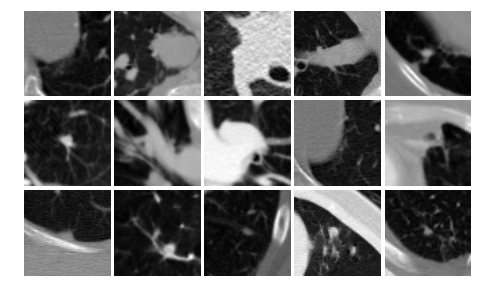

In [103]:
figure(figsize=(8, 5))
gray()
for i, pred_path in enumerate(high[15:30]):
    ax1 = subplot(3, 5, i + 1)
    ax1.autoscale_view('tight')
    imshow(load(pred_path[1])[31:34].max(0))
    axis('off')
subplots_adjust(wspace=.0511, hspace=-.10)

In [207]:
table = pickle.load(open(join(PATH['WEIGHTS'], 'table_nodules'), 'rb'))
df = pd.DataFrame(columns=['seriesuid', 'coordX', 
                           'coordY', 'coordZ', 
                           'class', 'probability'])
for uid, val in tqdm(zip(test, predicted_test)):
    table[basename(uid)[:-4]][0]['probability'] = val
    df = df.append(table[basename(uid)[:-4]][0])

53522it [08:13, 108.47it/s]


In [41]:
for uid, val in tqdm(zip(valid, predicted_valid)):
    table[basename(uid)[:-4]][0]['probability'] = val
    df = df.append(table[basename(uid)[:-4]][0])

26600it [07:14, 61.25it/s]


In [209]:
path = '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/I/LungCancerDetection/support/evaluationScript/annotations/seriesuids_we.csv'
seriesuid = pd.Series(unique(df.seriesuid.values))
seriesuid.to_csv(path, index=False)
path = '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/I/LungCancerDetection/support/evaluationScript/exampleFiles/submission/sampleSubmission_we.csv'
df.to_csv(path, index=False)

In [210]:
path = '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/I/LungCancerDetection/support/evaluationScript/annotations/annotations.csv'
annotations = pd.read_csv(path)
annotations = annotations[annotations.seriesuid.isin(seriesuid)]
path = '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/I/LungCancerDetection/support/evaluationScript/annotations/annotations_we.csv'
annotations.to_csv(path, index=False)

In [208]:
df.probability = df.probability.apply(lambda x: x[0])

In [53]:
def perf_measure(y_actual, y_hat, seriesuid):
    TP = 0
    seriesuid_unique = set(seriesuid)
    patients = dict(zip(seriesuid_unique, 
                        [0] * len(seriesuid_unique)))
    
    for act, hat in zip(y_actual, y_hat): 
        if act == hat == 1:
            TP += 1

    for act, hat, sid in zip(y_actual, y_hat, seriesuid): 
        if hat == 1 and act != hat:
            patients[sid] += 1
    
    return TP / y_actual.sum(), mean(list(patients.values()))

In [54]:
# seriesuid = [basename(path)[:64] for path in new_valid]
seriesuid = [basename(path)[:64] 
             for path in valid.tolist() + test.tolist()]
predicted = array(predicted_valid[:, 0].tolist() 
                  + predicted_test[:, 0].tolist())
        
labels = array(valid_labels.tolist() 
               + test_labels.tolist())

treshold = linspace(.0001, 1, 1000)
FROC = list()
for tr in tqdm(treshold):
    tresholded = predicted >= tr
    FROC.append(perf_measure(labels, tresholded, seriesuid))

100%|██████████| 1000/1000 [10:15<00:00,  1.72it/s]


In [492]:
seriesuid = [basename(path) 
             for path in new_valid + valid.tolist() + test.tolist()]
predicted = array(predicted_valid_new[:, 0].tolist() 
                  + predicted_valid[:, 0].tolist() 
                  + predicted_test[:, 0].tolist())
        
labels = array(new_valid_labels.tolist() 
               + valid_labels.tolist() 
               + test_labels.tolist())
predicted = list(zip(seriesuid, predicted))

In [494]:
# full = pickle.load(open(join(PATH['WEIGHTS'], 'full_nodules_description'), 'rb'))
df = pd.DataFrame(columns=['seriesuid', 'coordX', 'coordY', 'coordZ', 'class', 'probability'])

for skiped, patient in tqdm(reversed(full)):
    nodules = [(uid, val) for uid, val in predicted 
               if basename(uid)[:64] in patient[0]]
    
    nodules = sorted(nodules, key=lambda x: int(basename(x[0])[64:-4]))
    if not len(nodules):
        continue

    labels = asarray([val for uid, val in nodules])
    for row, val in zip(patient[1], labels):
        row[0]['probability'] = val
        df = df.append(row[0])

888it [09:57,  1.05s/it]


In [432]:
path = '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/I/LungCancerDetection/support/evaluationScript/annotations/annotations.csv'
df = pd.read_csv(path)
df = df[df.seriesuid.isin(seriesuid)]
path = '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/I/LungCancerDetection/support/evaluationScript/annotations/annotations_ed.csv'
df.to_csv(path, index=False)

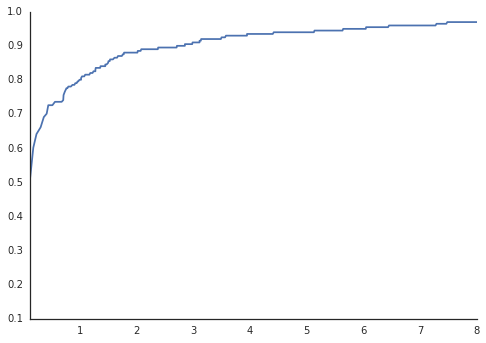

In [56]:
# sorted(FROC, key=lambda x: x[1])
sns.set_style('white')
FROC = asarray(FROC)
fig = subplot(111)
plot(FROC[1:, 1], FROC[1:, 0])
# fig.set_title("FFT")
fig.set_autoscaley_on(False)
fig.set_xlim([0.125, 8]);

# Hide the right and top spines
fig.spines['right'].set_visible(False)
fig.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
fig.yaxis.set_ticks_position('left')
fig.xaxis.set_ticks_position('bottom')

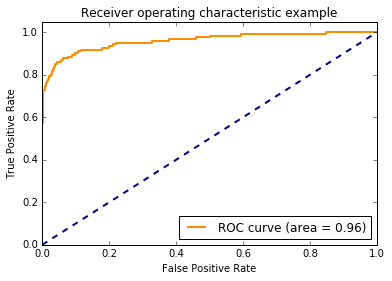

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()